<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>TP4 : Detecteur de Harris </center>
<hr style=" border:none; height:3px;">
</h1>




L'objectif de ce TP est de mettre au point votre propre détecteur de points d'intérêts en suivant la méthode de Harris (c.f. cours).

## Exercice 1 : calcul du critère de Harris
Il s'agit ici d'écrire une fonction ou un ensemble de fonctions permettant de renvoyer la carte des coins de Harris $ H = det C - \alpha (trace C)^{2}$ à partir d'une image donnée et pour une échelle donnée (taille de la fenêtre). On prendra $\alpha = 0.04$.

### Etape 1
Calcul de $I_{x}$ et $I_{y}$ gradient en $x$ et en $y$ d'une image lissée à l'aide de l'opérateur de Sobel.

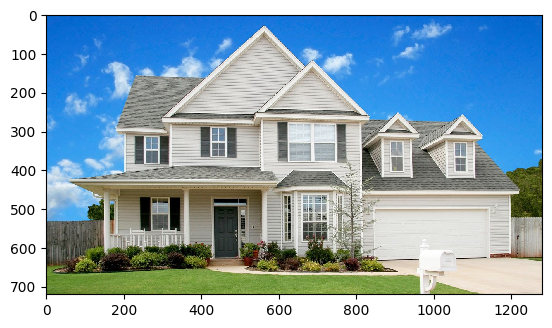

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2


def loadImagebis(src):
    img=cv2.imread(src,1)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,interpolation='nearest')
    plt.show()
    return img

img = loadImagebis('./Data/house.jpg')

In [2]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [3]:
sobelx = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img_gray,cv2.CV_64F,0,1,ksize=5)

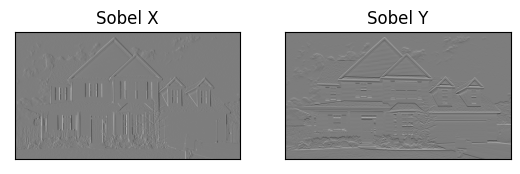

In [4]:
plt.subplot(1,2,1),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

### Etape 2
Calcul de $I_{x}^{2}$, $I_{y}^{2}$ et $I_{xy}= I_{x} \times I_{y}$

In [5]:
Ixx =np.multiply(sobelx,sobelx)
Iyy =np.multiply(sobely, sobely) 
Ixy=np.multiply(sobelx, sobely) 

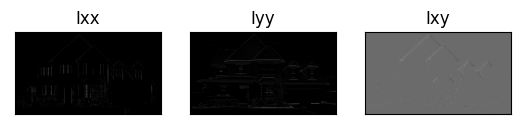

In [6]:
plt.subplot(1,3,1),plt.imshow(Ixx,cmap = 'gray')
plt.title('Ixx'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(Iyy,cmap = 'gray')
plt.title('Iyy'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(Ixy,cmap = 'gray')
plt.title('Ixy'), plt.xticks([]), plt.yticks([])
plt.show()


### Etape 3
Lisser avec un filtre gaussien de taille $N$ chacune des images précédentes.

In [7]:
Ixx_filtered = cv2.GaussianBlur(Ixx,(5,5),0.5)
Iyy_filtered = cv2.GaussianBlur(Iyy,(5,5),0.5)
Ixy_filtered = cv2.GaussianBlur(Ixy,(5,5),0.5)

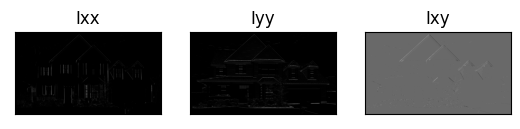

In [8]:
plt.subplot(1,3,1),plt.imshow(Ixx_filtered,cmap = 'gray')
plt.title('Ixx'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(Iyy_filtered,cmap = 'gray')
plt.title('Iyy'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(Ixy_filtered,cmap = 'gray')
plt.title('Ixy'), plt.xticks([]), plt.yticks([])
plt.show()

### Etape 4
En chaque pixel, calculer la fonction de Harris :$ H = det C - \alpha (trace C)^{2}$ avec $\alpha = 0.04$


In [9]:
k = 0.04

# determinant
detA = Ixx * Iyy - Ixy ** 2
# trace
traceA = Ixx + Iyy
    
harris_response =detA - k * traceA ** 2




Appliquer sur l'image de maison et afficher l'image $H$. 

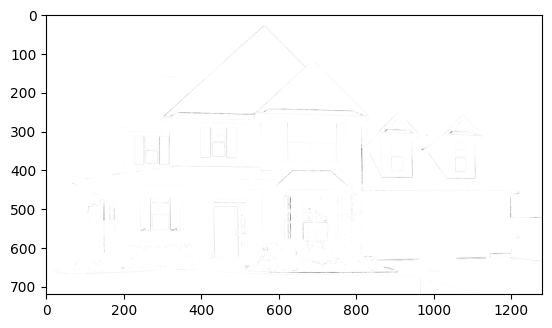

In [10]:
plt.imshow(harris_response,cmap = 'gray')
plt.show()

## Exercice 2 : détection des coins

Il s'agit ici de mettre en place les fonctions pour détecter les coins à partir de la carte des coins construite dans la partie précédente.

Ecrire une fonction permettant de binariser la carte des coins par une opération de seuillage.

(-0.5, 1279.5, 719.5, -0.5)

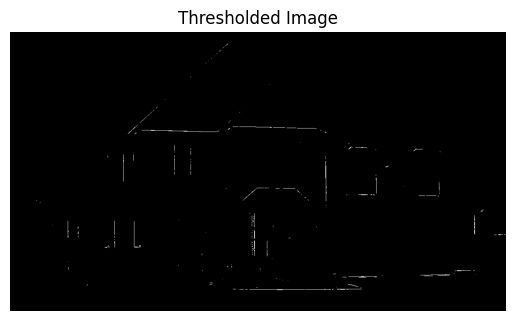

In [11]:
# Threshold the image
ratio = .2 # Number to tweak
thresh = abs(harris_response) > ratio * abs(harris_response).max()
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

Ecrire une fonction permettant d'extraire les maxima locaux sur un voisinage $3 \times 3$ (mettre à 0 dans l'image binarisée tous les points  dont la valeur n'est pas supérieure à celle des 8 voisins ) 

In [12]:

# Compute non-maximal supression

# Get the indexes of the non zero values
non_zero_cords = np.nonzero(thresh)

# Tupled Co-ordinates
tuple_cords = [(i, j) for i,j in zip(non_zero_cords[0], non_zero_cords[1])] 
# Values at the these co-ordinates
values = [abs(harris_response)[i, j] for i, j in tuple_cords]
# Sort the co-ordinates based on the R values
sorted_cords = [tuple_cords[i] for i in np.argsort(values)[::-1]]
# Set Distance to perform non-maximal supression
# Any point with this distance of an 
# already selected point will be suppressed
distance = 10 # Number to tweak 
# List to hold the cords after NMS
nms_cords = []
nms_cords.append(sorted_cords[0])
for cord in sorted_cords:
    for nms_cord in nms_cords:
        if abs(cord[0]-nms_cord[0]) < distance and abs(cord[1]-nms_cord[1]) < distance:
            break
    else:
        nms_cords.append(cord)
print("Number of points detected before NMS = {} ".format(sum(thresh)))
print("Number of points detected after NMS = {} ".format(len(nms_cords)))


Number of points detected before NMS = [0 0 0 ... 1 1 1] 
Number of points detected after NMS = 244 


Ecrire une fonction permettant d'afficher les points détectés en dessinant un rond bleu en chaque point sur l'image originale.

(-0.5, 1279.5, 719.5, -0.5)

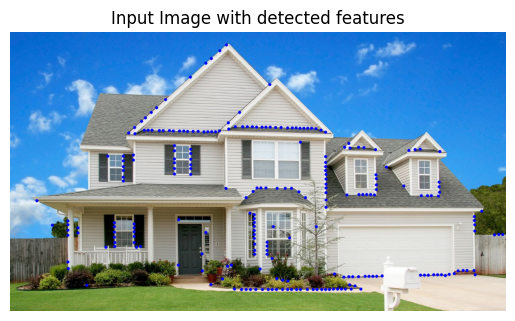

In [13]:
# Draw the image with the detected corners
for nms_cord in nms_cords:
    cv2.circle(img, (nms_cord[1], nms_cord[0]), 4, (255, 0, 0), -1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Input Image with detected features')
plt.axis('off')

Appliquer sur l'image de maison

## Exercice 3
Plusieurs fonctions sont disponibles dans OpenCV pour le calcul de points d'intérêts. :
+ [cornerHarris](http://docs.opencv.org/3.2.0/dc/d0d/tutorial_py_features_harris.html)
+ [cornerSubPix](http://docs.opencv.org/3.2.0/dc/d0d/tutorial_py_features_harris.html)
+ [goodFeaturesToTrack](http://docs.opencv.org/3.2.0/d4/d8c/tutorial_py_shi_tomasi.html) qui correspond à l'approche de Shi Tomasi
+ [SIFT](http://docs.opencv.org/3.2.0/da/df5/tutorial_py_sift_intro.html)

Documentez vous sur ces différentes fonctions et utilisez les pour calculer des points d'intérêts sur différentes images et notamment l'image (les images) utilisées dans la première partie de ce TP.

